In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'cmu serif'

page_width = 6.75 # aistats width
# single col: 3.25

In [4]:
ds_name = 'cifar20_100'

In [5]:
results_path = f'../runs_00_final/{ds_name}/softmax'

In [15]:
l2d_type_lst = ['single', 'single_finetune', 'pop', 'pop_attn_sa']
p_out_lst = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]
seed_lst = [1071,3918,4420,5251,6637]
metrics_lst = ['cov', 'sys_acc', 'exp_acc', 'clf_acc', 'exp_acc_alone', 'clf_acc_alone', 'val_loss']

results = {}
for l2d_type in l2d_type_lst:
    results[l2d_type] = {}
    metrics_all = {metric:[[] for _ in range(len(p_out_lst))] for metric in metrics_lst}

    for ii,p_out in enumerate(p_out_lst):
        for seed in seed_lst:
            if l2d_type != 'single_finetune':
                fn_path = os.path.join(results_path, f'l2d_{l2d_type}', f'p{p_out}_seed{seed}', 'eval1.0.log')
            else:
                fn_path = os.path.join(results_path, f'l2d_single', f'p{p_out}_seed{seed}', 'eval1.0_finetune.log')

            try:
                line = open(fn_path).readline().rstrip()
            except FileNotFoundError:
                print(fn_path)
            else:
                line_split_grp = [line.split()[i:i+2] for i in range(0, len(line.split()),2)]
                for [metric,val] in line_split_grp:
                    if metric=='cov':
                        cov = val.split('/')
                        metrics_all[metric][ii].append(int(cov[0])/int(cov[1]))
                    else:
                        metrics_all[metric][ii].append(float(val))

    for metric, vals in metrics_all.items():
        results[l2d_type][metric] = np.vstack(vals)

In [16]:
c_red = mpl.colormaps['Set1'](0)
c_blue = mpl.colormaps['Set1'](1)

In [17]:
metrics_to_text = {
    'cov':'Coverage',
    'sys_acc': 'System accuracy (\%)',
    'exp_acc': 'Expert accuracy\non deferred examples (\%)',
    'clf_acc': 'Classifier accuracy\n on non-deferred examples',
    'clf_acc_alone': 'Classifier accuracy\n on all examples',
    'val_loss': 'Test loss'
}

In [18]:
l2d_type_to_text = {
    'single': 'Single-expert',
    'single_finetune': 'Single-expert (finetune)',
    'pop': 'Population',
    'pop_attn_sa': 'Pop. w/ attention',
}

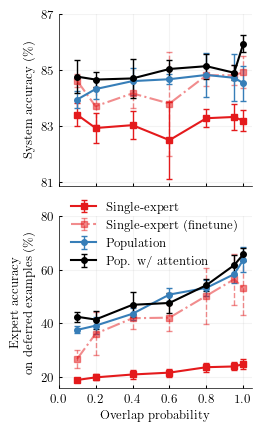

In [45]:
fig,axs = plt.subplots(2,1,figsize=(2.5,4.2), constrained_layout=True)

metric_to_col = {'single':c_red,'pop':c_blue, 'pop_attn_sa':'k', 'single_finetune':c_red}
metric_to_marker = {'single':'s-','pop':'o-', 'pop_attn_sa':'o-', 'single_finetune':'s-.'}
errbar_args={'capsize':2, 'markersize':4, 'elinewidth':1, 'capthick':1, 'lw':1.5} # 'fmt':'o-'

fs_ax_lbl=9
fs_ax_ticks = 9
fs_ax_title = 9

for ax,metric in zip(axs,['sys_acc','exp_acc']):
    for l2d_type in l2d_type_lst:
        metric_mean = np.mean(results[l2d_type][metric], axis=1)
        metric_std = np.std(results[l2d_type][metric], axis=1)
        overlap_prob = np.array(p_out_lst)
        if l2d_type == 'single_finetune':
            eb1 = ax.errorbar(overlap_prob, metric_mean, yerr=metric_std, label=l2d_type_to_text[l2d_type], \
                    c=metric_to_col[l2d_type], fmt=metric_to_marker[l2d_type], alpha=0.5, **errbar_args)
            eb1[-1][0].set_linestyle('--')
        else:
            ax.errorbar(overlap_prob, metric_mean, yerr=metric_std, label=l2d_type_to_text[l2d_type], \
                    c=metric_to_col[l2d_type], fmt=metric_to_marker[l2d_type], **errbar_args)
        
    ax.set_xticks([0,0.2,0.4,0.6,0.8,1])

    ax.set_ylabel(metrics_to_text[metric], fontsize=fs_ax_lbl)
    ax.grid(True, alpha=0.15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(direction='in', labelsize=fs_ax_ticks,length=2., width=0.75)
    [x.set_linewidth(.5) for x in ax.spines.values()]

axs[0].tick_params(labelbottom=False)    
axs[1].set_xlabel('Overlap probability', fontsize=fs_ax_lbl)
axs[1].set_yticks([20,40,60,80])
axs[0].set_yticks([81,83,85,87])
leg = axs[1].legend(fontsize=fs_ax_title, frameon=False, bbox_to_anchor=(0.5, 1.15), loc='upper center');
leg.get_frame().set_linewidth(0.5)

# fig.savefig(f'exp_{ds_name}_finetune.pdf', dpi=600, facecolor='white', bbox_inches='tight', pad_inches=0.01)
# fig.savefig(f'exp_{ds_name}.png', dpi=600, facecolor='white', bbox_inches='tight', pad_inches=0.01)